Auteur : Audrey Hohmann

# Projet P7 : Notebook_EDA_feature_engineering
 
## Mission : Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique. 

## Data : Kaggle Home Credit Default Risk

Notebook inspiré des notebooks kaggle suivants : 
* https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script?utm_medium=email&utm_content=nov-18-has-completed-mentoring-session-student&bsft_clkid=c383d801-b816-4d91-bed2-bce1da1df289&bsft_uid=54d38473-b877-4917-828f-57101c869f00&bsft_mid=8b2cf8bc-ff00-49bd-ba21-f71f9e476cd2&bsft_eid=7244055d-47f0-a6f2-c394-7a20ebb3a726&bsft_txnid=71f40185-343e-4c6f-9a7d-c87d70160352&bsft_mime_type=html&bsft_ek=2023-06-09T08%3A34%3A41Z&bsft_aaid=a265d396-7432-4eb2-9c9a-ba5eea75629e&bsft_tv=13
* https://www.kaggle.com/code/profammons/eda-feature-engineering-and-supervised-ml#Feature-Engineering
* https://www.kaggle.com/code/syahbima/home-credit-risk-modelling
* https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering/notebook#Feature-Engineering-Outcomes

In [129]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import gc

sns.set_theme()

from matplotlib import pyplot as plt
import missingno as msno

%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [58]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [59]:
pd.options.mode.chained_assignment = None 

In [60]:
import warnings
warnings.filterwarnings('ignore')

# Data description

*application_{train|test}.csv --
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

*bureau.csv --
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

*bureau_balance.csv --
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

*POS_CASH_balance.csv --
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

*credit_card_balance.csv --
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

*previous_application.csv --
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

*installments_payments.csv --
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

*HomeCredit_columns_description.csv --
This file contains descriptions for the columns in the various data files.

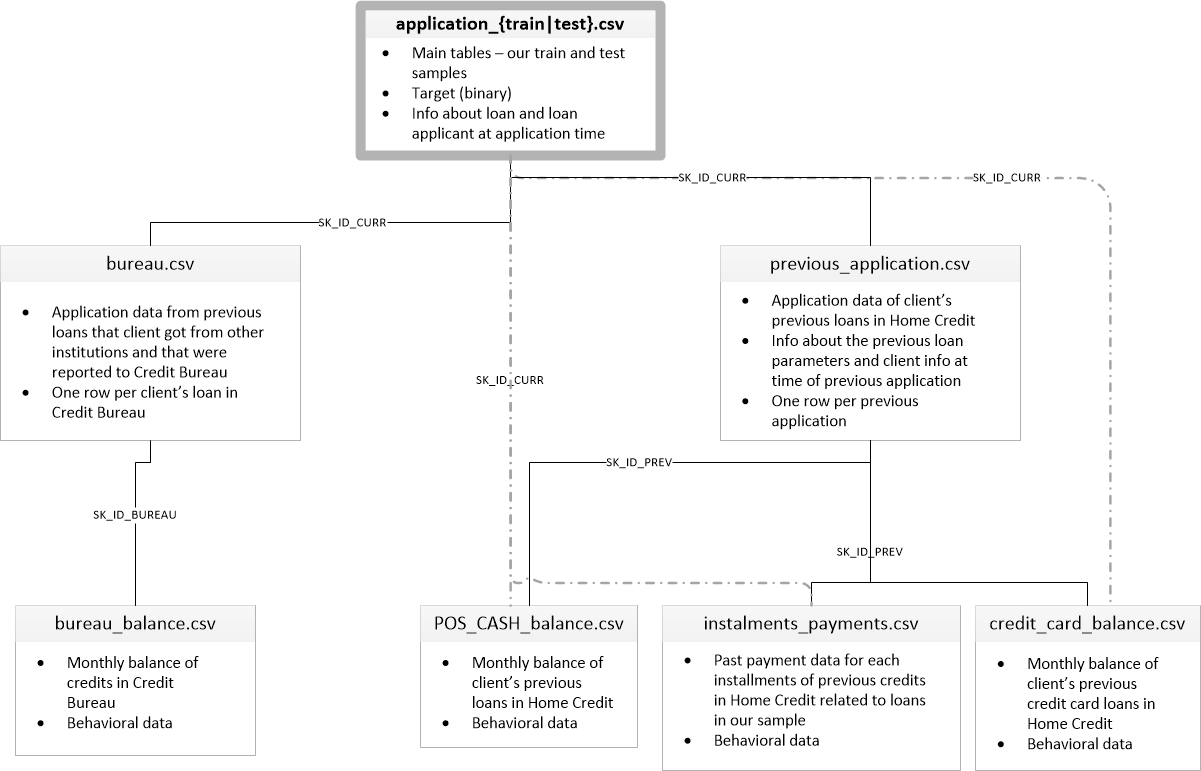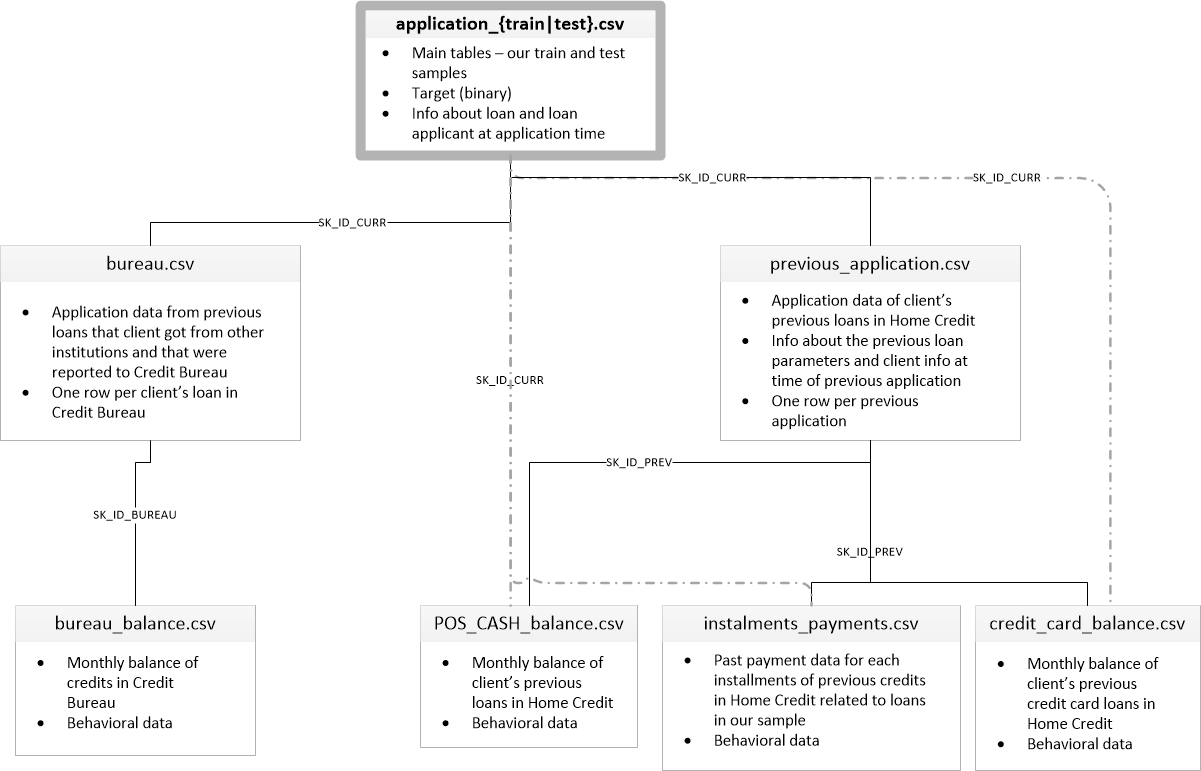

# DATA LOAD

In [21]:
PATH=""

In [131]:
application_train = pd.read_csv(PATH+"application_train.csv")
application_test = pd.read_csv(PATH+"application_test.csv")
bureau_df = pd.read_csv(PATH+"bureau.csv")
bureau_balance = pd.read_csv(PATH+"bureau_balance.csv")
credit_card_balance_df = pd.read_csv(PATH+"credit_card_balance.csv")
installments_payments_df = pd.read_csv(PATH+"installments_payments.csv")
previous_application = pd.read_csv(PATH+"previous_application.csv")
POS_CASH_balance = pd.read_csv(PATH+"POS_CASH_balance.csv")

In [133]:
print('Size of application_train data', application_train.shape)
print('Size of application_test data', application_test.shape)
print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments_df.shape)
print('Size of credit_card_balance data', credit_card_balance_df.shape)
print('Size of bureau data', bureau_df.shape)

Size of application_train data (307511, 122)
Size of application_test data (48744, 121)
Size of POS_CASH_balance data (10001358, 8)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)
Size of bureau data (1716428, 17)


In [24]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [26]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [27]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [28]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [29]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


# Data exploration and Data cleaning

In [31]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [32]:
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [33]:
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [34]:
df_pie = application_train['TARGET'].value_counts(normalize=True)
df_pie

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

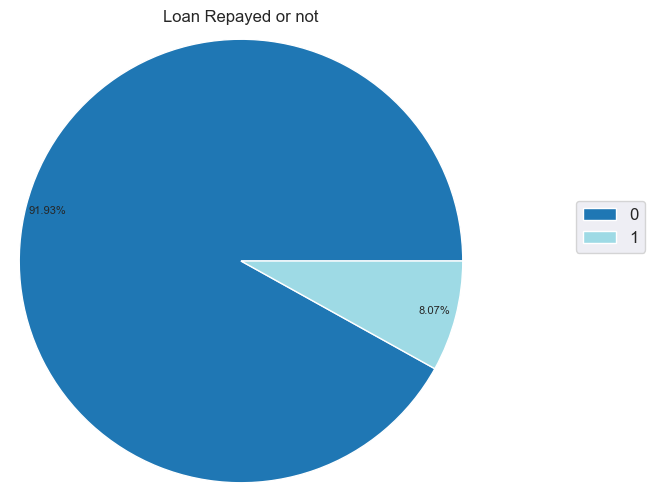

In [43]:
lab=df_pie.index.unique()
pie=df_pie.plot.pie(labels=None, figsize=(10,6), startangle=0, title="Loan Repayed or not",
                   autopct='%1.2f%%', pctdistance=0.9, radius=1.2, colormap='tab20', fontsize=8)
pie.legend(lab, loc='lower center', bbox_to_anchor=(0.8, 0.5, 1, 1), fontsize=12)
pie.axes.get_yaxis().set_visible(False)
plt.show()

classe target déséquilibrée : il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés.

## missing and duplicated data

In [44]:
application_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [45]:
application_train.duplicated(subset=['SK_ID_CURR']).sum()

0

<AxesSubplot: >

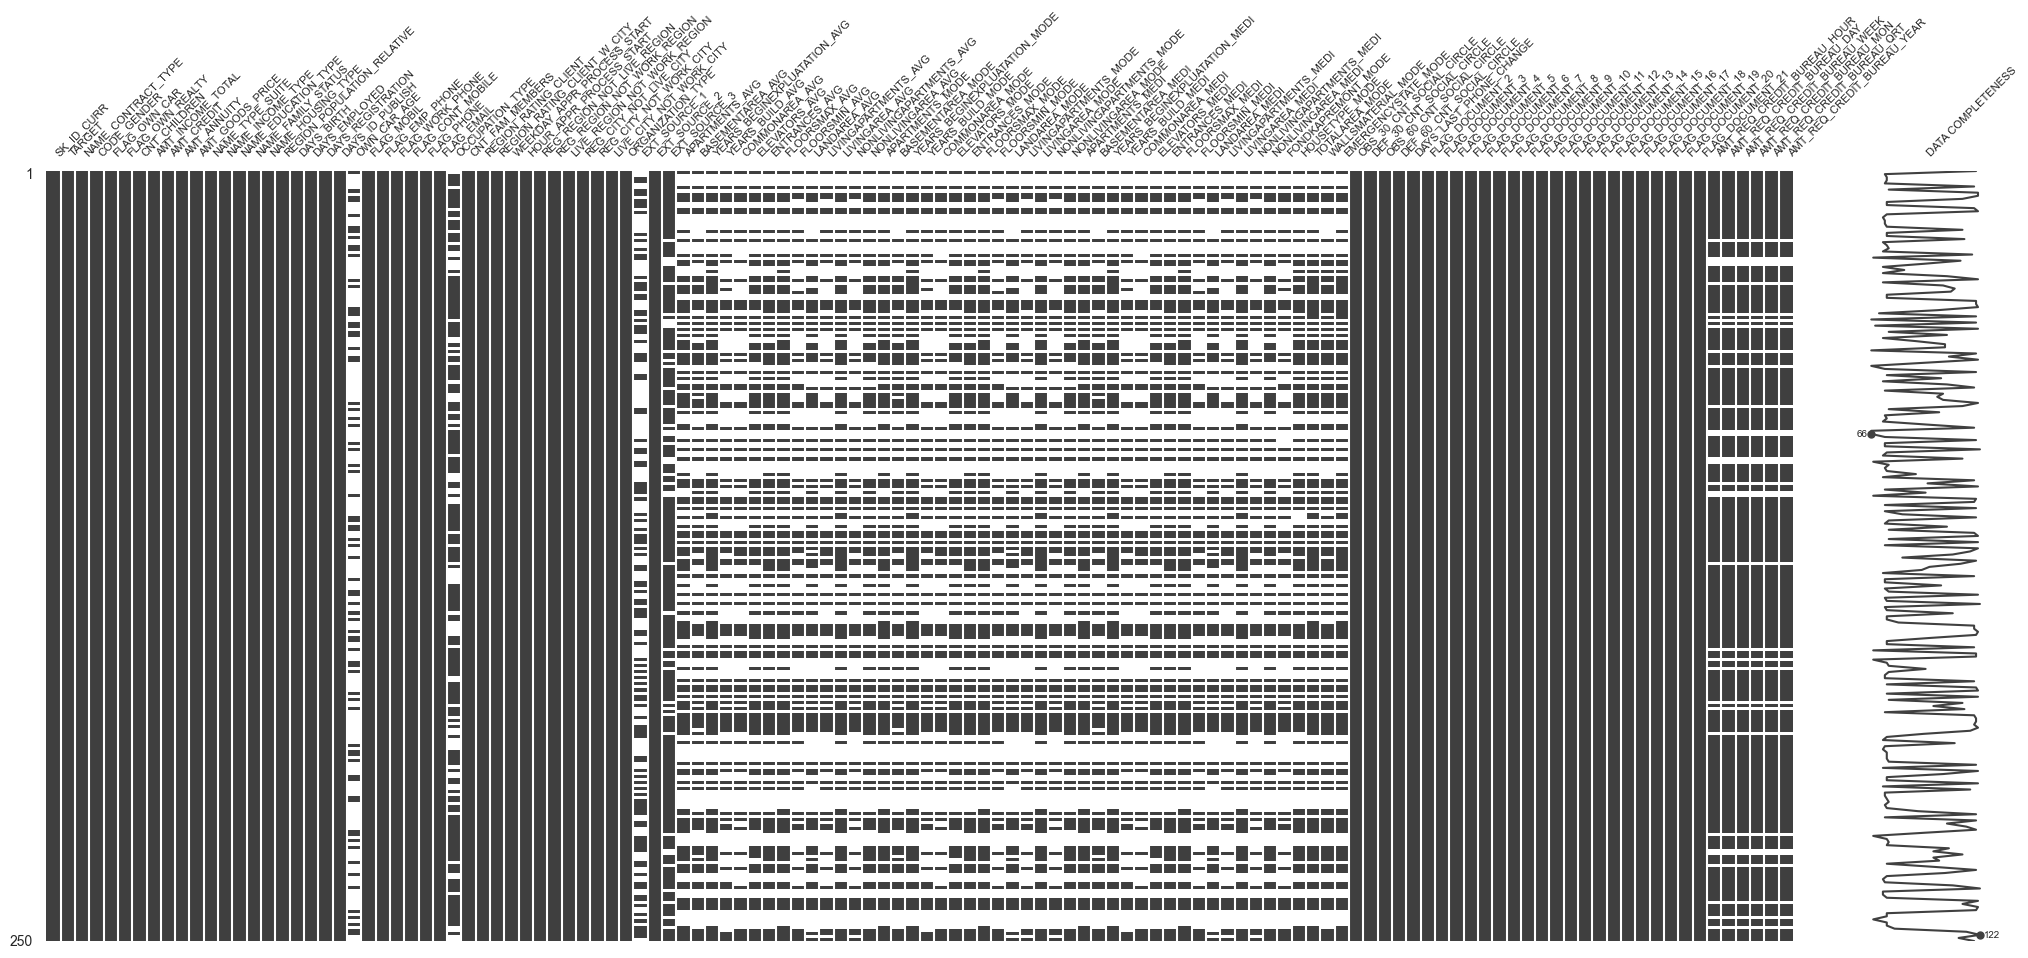

In [46]:
msno.matrix(application_train.sample(250), labels=True, fontsize=8)

In [47]:
application_train.isna().mean().sort_values(ascending=True)

SK_ID_CURR                      0.000000
HOUR_APPR_PROCESS_START         0.000000
REG_REGION_NOT_WORK_REGION      0.000000
LIVE_REGION_NOT_WORK_REGION     0.000000
REG_CITY_NOT_LIVE_CITY          0.000000
REG_CITY_NOT_WORK_CITY          0.000000
LIVE_CITY_NOT_WORK_CITY         0.000000
ORGANIZATION_TYPE               0.000000
FLAG_DOCUMENT_21                0.000000
FLAG_DOCUMENT_20                0.000000
FLAG_DOCUMENT_19                0.000000
FLAG_DOCUMENT_18                0.000000
FLAG_DOCUMENT_17                0.000000
FLAG_DOCUMENT_16                0.000000
FLAG_DOCUMENT_15                0.000000
FLAG_DOCUMENT_14                0.000000
FLAG_DOCUMENT_13                0.000000
FLAG_DOCUMENT_12                0.000000
FLAG_DOCUMENT_11                0.000000
FLAG_DOCUMENT_10                0.000000
FLAG_DOCUMENT_9                 0.000000
FLAG_DOCUMENT_8                 0.000000
FLAG_DOCUMENT_7                 0.000000
FLAG_DOCUMENT_6                 0.000000
FLAG_DOCUMENT_5 

In [37]:
# remove columns
df_train = application_train.loc[:,(application_train.isna().mean() < 0.50)]

In [38]:
df_train.shape

(307511, 81)

## Anomalies Detection

In [39]:
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [40]:
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
EMERGENCYSTATE_MODE            2
dtype: int64

In [41]:
df_train.select_dtypes('object').apply(pd.Series.unique, axis = 0)

NAME_CONTRACT_TYPE                                [Cash loans, Revolving loans]
CODE_GENDER                                                         [M, F, XNA]
FLAG_OWN_CAR                                                             [N, Y]
FLAG_OWN_REALTY                                                          [Y, N]
NAME_TYPE_SUITE               [Unaccompanied, Family, Spouse, partner, Child...
NAME_INCOME_TYPE              [Working, State servant, Commercial associate,...
NAME_EDUCATION_TYPE           [Secondary / secondary special, Higher educati...
NAME_FAMILY_STATUS            [Single / not married, Married, Civil marriage...
NAME_HOUSING_TYPE             [House / apartment, Rented apartment, With par...
OCCUPATION_TYPE               [Laborers, Core staff, Accountants, Managers, ...
WEEKDAY_APPR_PROCESS_START    [WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY...
ORGANIZATION_TYPE             [Business Entity Type 3, School, Government, R...
EMERGENCYSTATE_MODE                     

In [42]:
len(df_train[df_train['CODE_GENDER'] == 'XNA'])

4

In [43]:
df_train = df_train[df_train['CODE_GENDER'] != 'XNA']

In [44]:
df_train.shape

(307507, 81)

In [45]:
(df_train['DAYS_BIRTH'] / -365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [46]:
(df_train['DAYS_EMPLOYED'] / -365).describe()

count    307507.000000
mean       -174.838162
std         387.058829
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

The Data '365,243' seem like number of days in a year and number of working days in a year is combined.
The days divided by 365 gives around 1000 years, which is not possible at all. 

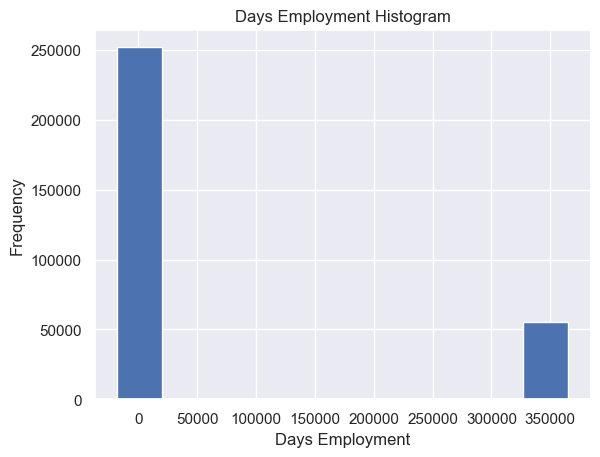

In [47]:
df_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [48]:
anom_de = df_train[df_train['DAYS_EMPLOYED'] == 365243]
non_anom_de = df_train[df_train['DAYS_EMPLOYED'] != 365243]
print(f"The non-anomalies mean credit amount of loans are {non_anom_de['AMT_CREDIT'].mean()}")
print(f"The anomalies mean credit amount of loans are {anom_de['AMT_CREDIT'].mean()}")
print(f"There are {len(anom_de)} anomalous days of employment")

The non-anomalies mean credit amount of loans are 611401.821259018
The anomalies mean credit amount of loans are 542689.9139668436
There are 55374 anomalous days of employment


365243 seems to be number entered when there's no data available.
The distribution of 365243 ( missing values ) doesnt seem to have any pattern, but there is indeed credit amount associated. 
The best appraoch is to fill it with NaN values, deal with it later when we deal with missing values. 

### bug fixes

In [49]:
# Create an anomalous flag column
df_train['DAYS_EMPLOYED_ANOM'] = df_train["DAYS_EMPLOYED"] == 365243

In [50]:
#Replace the anomalous values with nan
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

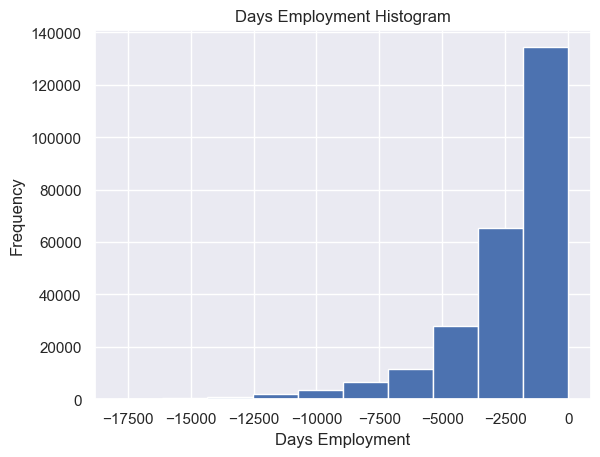

In [51]:
df_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

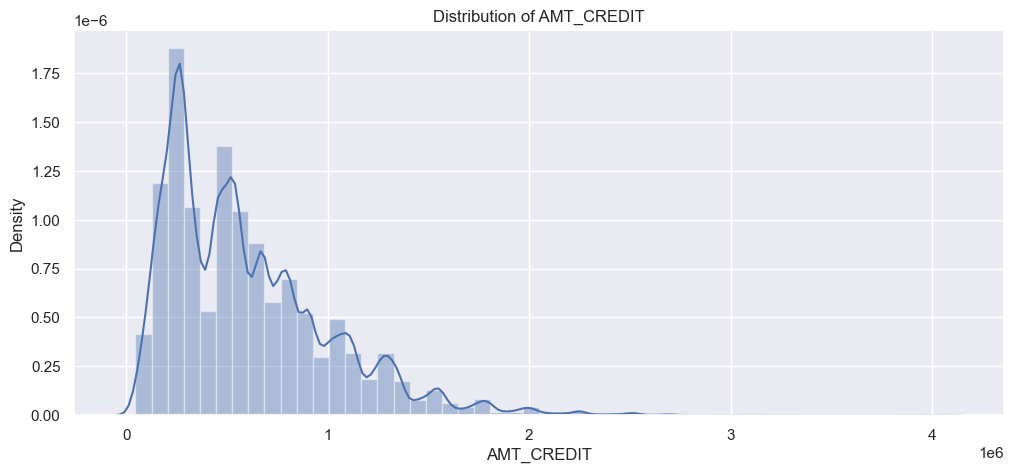

In [61]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(df_train["AMT_CREDIT"])

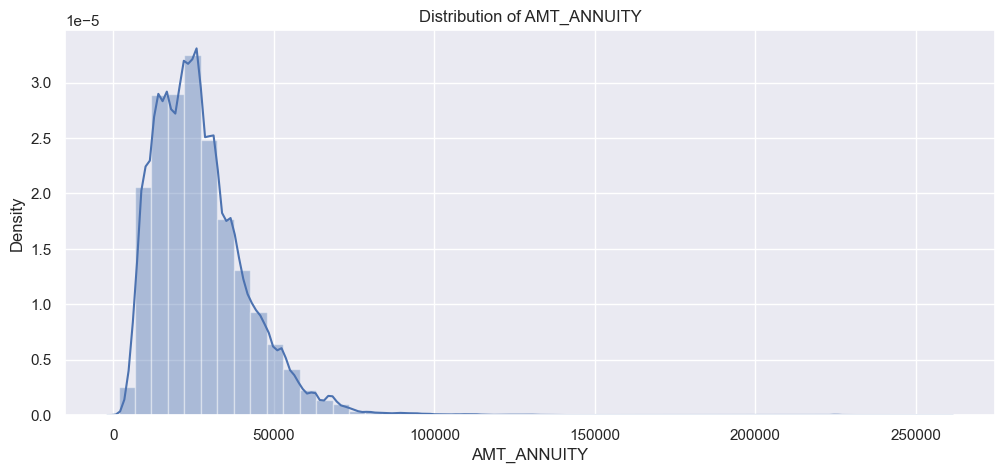

In [62]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_ANNUITY")
ax = sns.distplot(df_train["AMT_ANNUITY"].dropna())

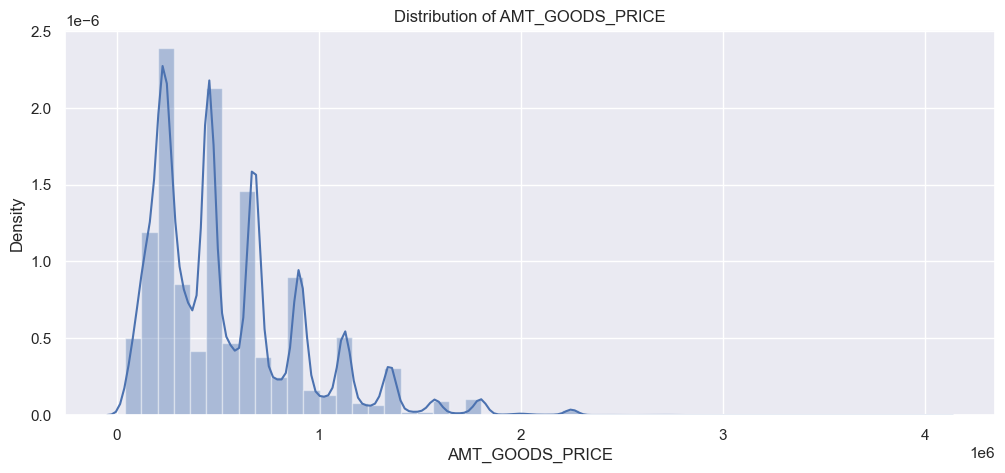

In [63]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(application_train["AMT_GOODS_PRICE"].dropna())

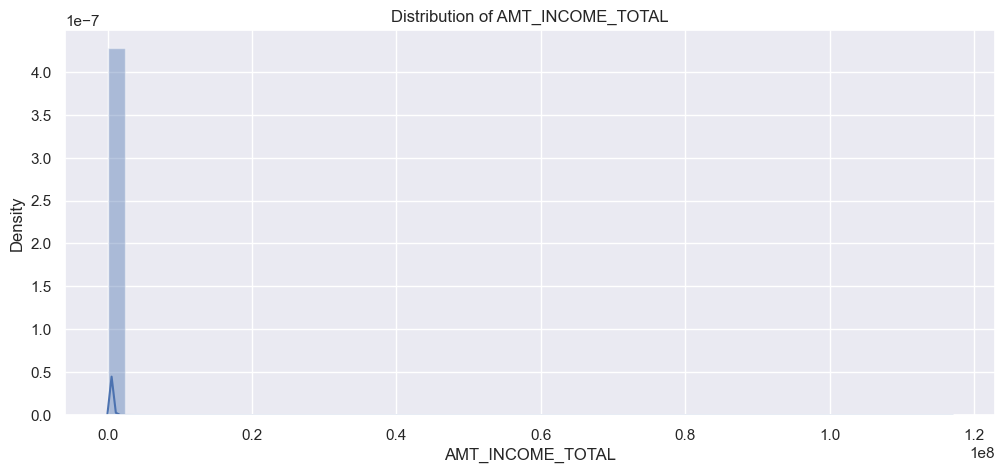

In [64]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_INCOME_TOTAL")
ax = sns.distplot(df_train["AMT_INCOME_TOTAL"])

In [65]:
df_train["AMT_INCOME_TOTAL"].skew()

391.5574134299243

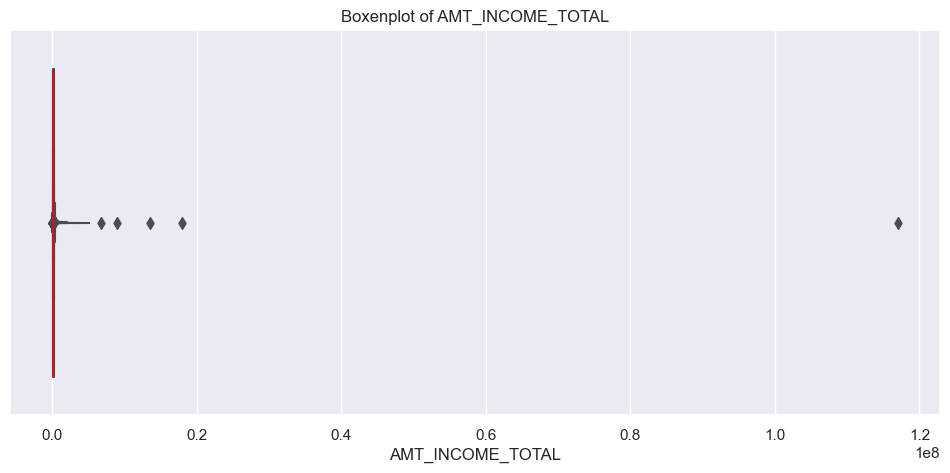

In [66]:
plt.figure(figsize=(12,5))
plt.title("Boxenplot of AMT_INCOME_TOTAL")
ax= sns.boxenplot(data=df_train, x="AMT_INCOME_TOTAL", line_kws=dict(color="red", alpha=0.7))

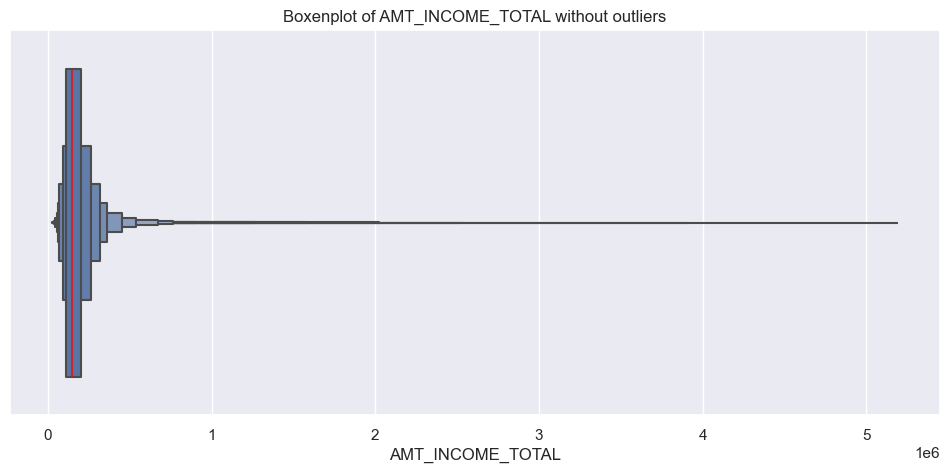

In [67]:
plt.figure(figsize=(12,5))
plt.title("Boxenplot of AMT_INCOME_TOTAL without outliers")
ax= sns.boxenplot(data=df_train, x="AMT_INCOME_TOTAL",showfliers=False, line_kws=dict(color="red", alpha=0.7))

In [68]:
round(df_train["AMT_INCOME_TOTAL"].quantile([0.5,0.75,0.8,0.9,0.95,0.99,1]))

0.50       147150.0
0.75       202500.0
0.80       225000.0
0.90       270000.0
0.95       337500.0
0.99       472500.0
1.00    117000000.0
Name: AMT_INCOME_TOTAL, dtype: float64

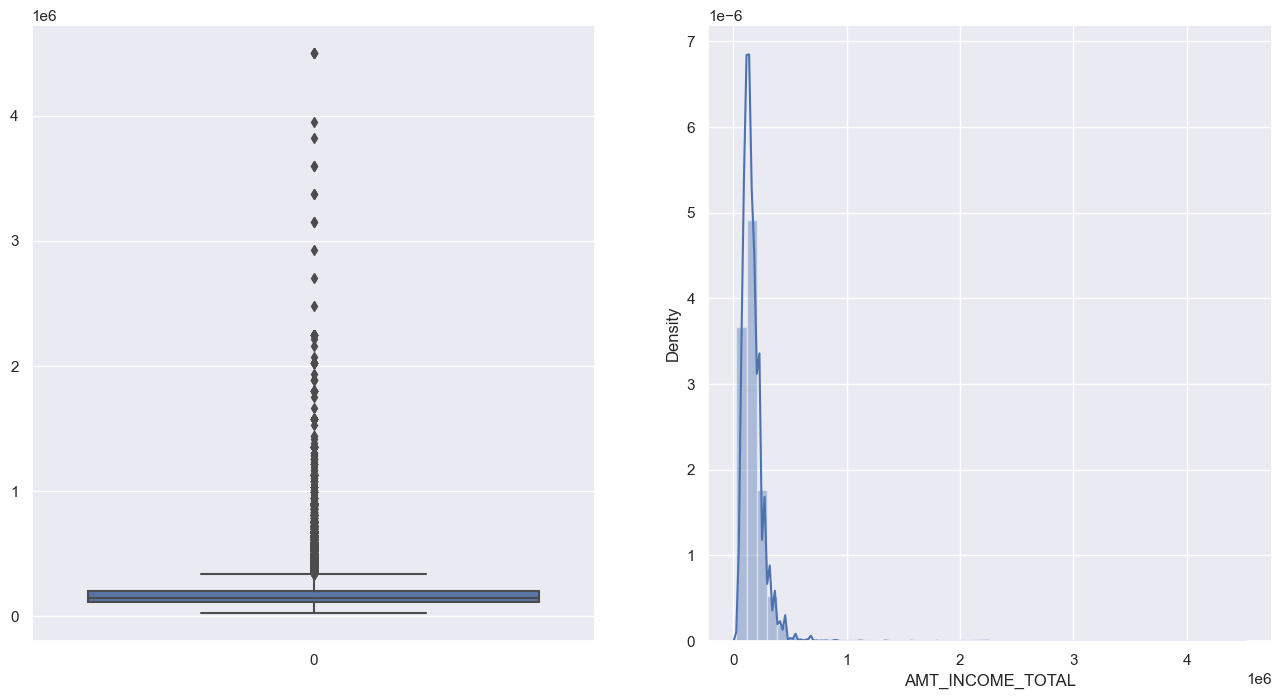

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.boxplot(df_train.loc[(df_train["AMT_INCOME_TOTAL"] <= 4725000.0), "AMT_INCOME_TOTAL"] , ax=axes[0])
sns.distplot(df_train.loc[(df_train["AMT_INCOME_TOTAL"] <= 4725000.0), "AMT_INCOME_TOTAL"], ax=axes[1])
plt.show()

In [70]:
print(df_train[df_train['AMT_INCOME_TOTAL'] >= 600000.00].shape[0])
round(df_train[df_train['AMT_INCOME_TOTAL'] >= 600000.00].shape[0]/df_train.shape[0]*100,2)

1607


0.52

Let's drop all the records with income greater than 600K which only drops 0.5% of data

In [71]:
df_train2 = df_train[df_train['AMT_INCOME_TOTAL'] < 600000]
df_train2.shape

(305900, 82)

## Correlation

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. <br> 
According to literature, we can consider that :  <br>
*.00-.19 “very weak”  <br>
*.20-.39 “weak”  <br>
*.40-.59 “moderate”  <br>
*.60-.79 “strong”  <br>
*.80-1.0 “very strong”  <br>

#### with the target

In [74]:
cor_target = df_train2.corr()['TARGET'].sort_values()

In [75]:
# Display correlations
print('Most Positive Correlations:\n', cor_target.tail(15))
print('\nMost Negative Correlations:\n', cor_target.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031331
DEF_30_CNT_SOCIAL_CIRCLE       0.032305
LIVE_CITY_NOT_WORK_CITY        0.032515
DAYS_REGISTRATION              0.042266
FLAG_DOCUMENT_3                0.044067
REG_CITY_NOT_LIVE_CITY         0.044435
FLAG_EMP_PHONE                 0.046249
REG_CITY_NOT_WORK_CITY         0.050979
DAYS_ID_PUBLISH                0.051584
DAYS_LAST_PHONE_CHANGE         0.055584
REGION_RATING_CLIENT           0.058614
REGION_RATING_CLIENT_W_CITY    0.060603
DAYS_EMPLOYED                  0.075030
DAYS_BIRTH                     0.078469
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.179119
EXT_SOURCE_2                 -0.160458
DAYS_EMPLOYED_ANOM           -0.046256
FLOORSMAX_AVG                -0.043585
FLOORSMAX_MEDI               -0.043342
FLOORSMAX_MODE               -0.042788
AMT_GOODS_PRICE              -0.038728
REGION_POPULATION_RELATIVE   -0.036606


In [76]:
abs(df_train2['DAYS_BIRTH']).corr(df_train2['TARGET'])

-0.07846927548652421

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

In [72]:
df_train2['DAYS_BIRTH'] = abs(df_train2['DAYS_BIRTH'])

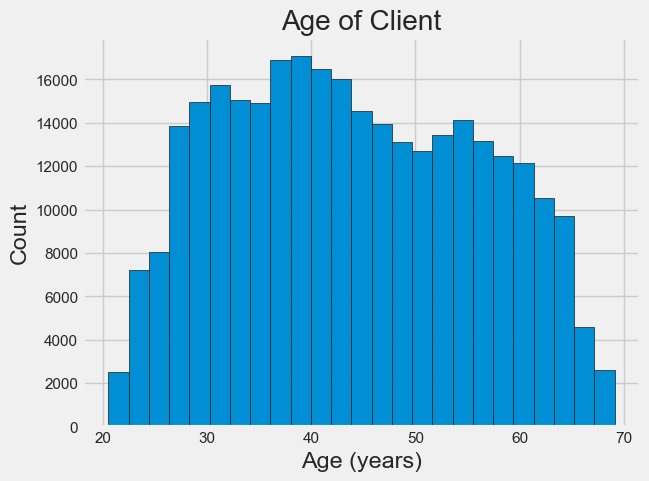

In [78]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(df_train2['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

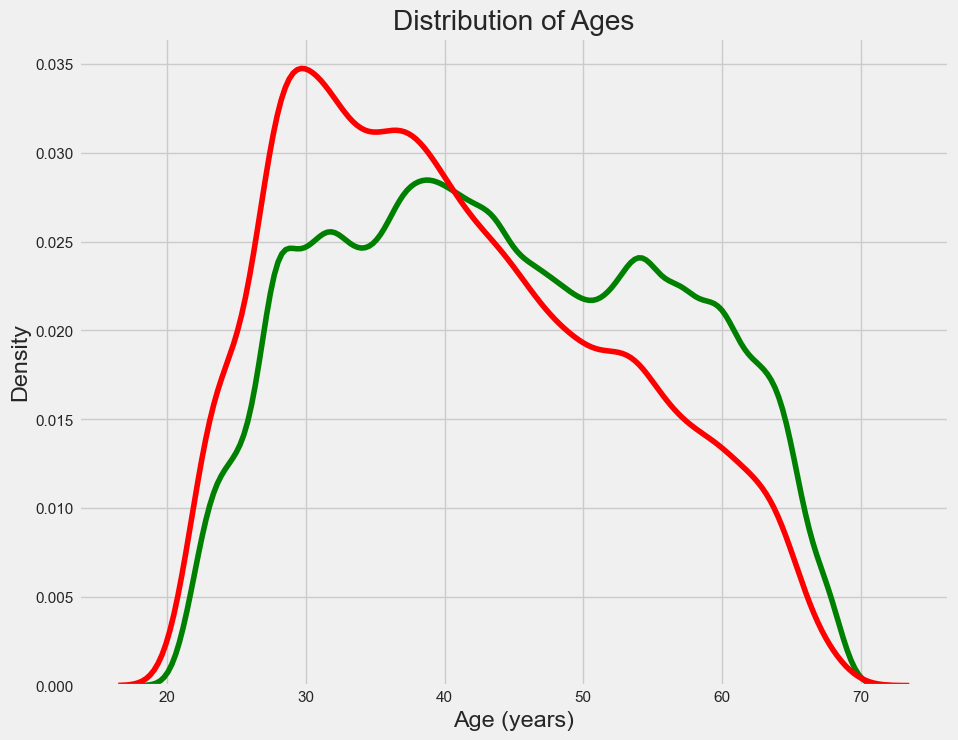

In [79]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_train2.loc[df_train2['TARGET'] == 0, 'DAYS_BIRTH'] / 365, color="green", label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_train2.loc[df_train2['TARGET'] == 1, 'DAYS_BIRTH'] / 365, color="red", label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 red curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [80]:
# Age information into a separate dataframe
age_data = df_train2[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [81]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123128,8532.741399,23.377374
"(25.0, 30.0]",0.111641,10154.744659,27.821218
"(30.0, 35.0]",0.103144,11854.581840,32.478306
"(35.0, 40.0]",0.089756,13707.778193,37.555557
"(40.0, 45.0]",0.078547,15497.537790,42.459008
"(45.0, 50.0]",0.074310,17324.676099,47.464866
"(50.0, 55.0]",0.067142,19196.825971,52.594044
"(55.0, 60.0]",0.055478,20984.424604,57.491574
"(60.0, 65.0]",0.052760,22780.476740,62.412265


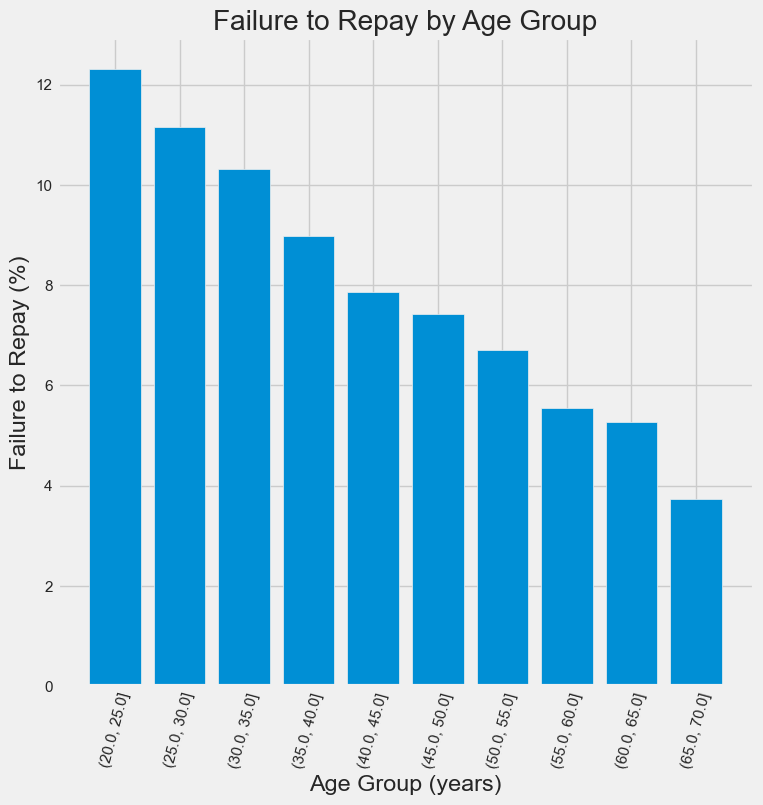

In [82]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

In [83]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_train2[['TARGET', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.160458,-0.179119,-0.078469
EXT_SOURCE_2,-0.160458,1.000000,0.109728,0.092409
EXT_SOURCE_3,-0.179119,0.109728,1.000000,0.205978
DAYS_BIRTH,-0.078469,0.092409,0.205978,1.000000


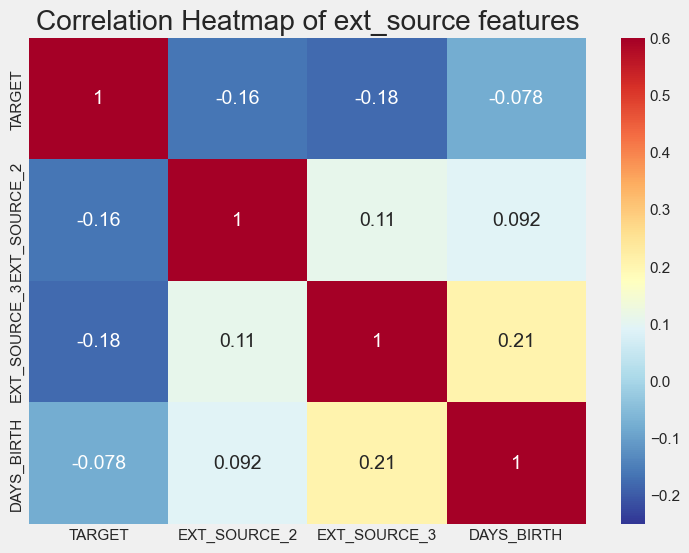

In [84]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap of ext_source features');

All three EXT_SOURCE featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan.

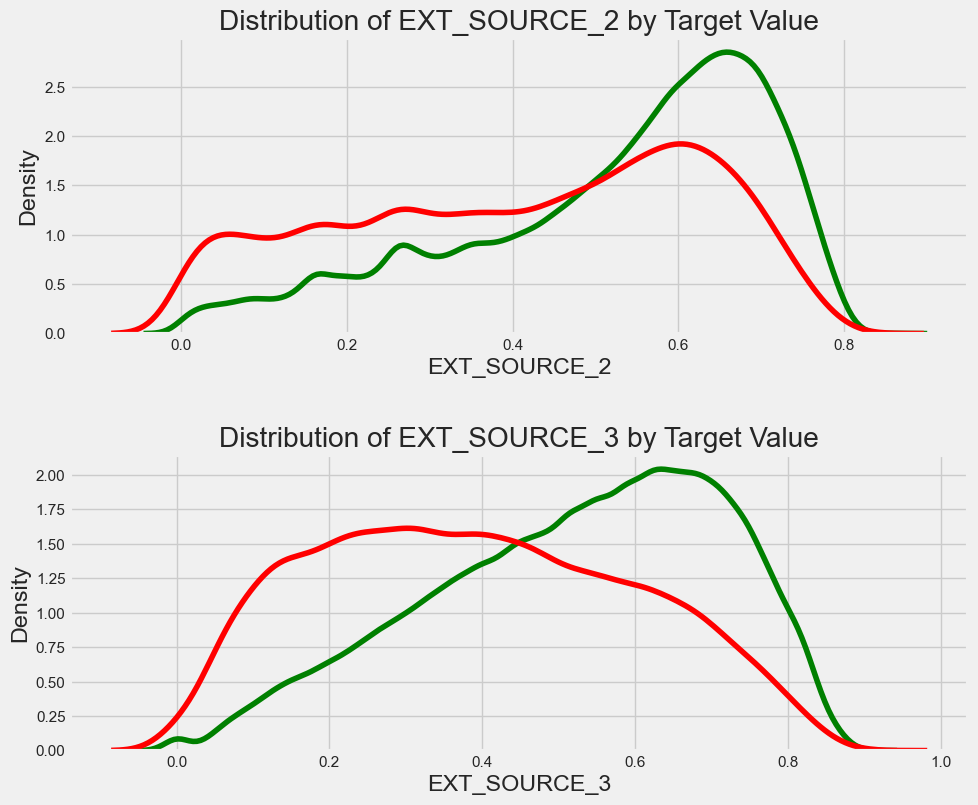

In [85]:
plt.figure(figsize = (10, 12))

df = df_train2
# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, source], color="green", label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, source], color="red", label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

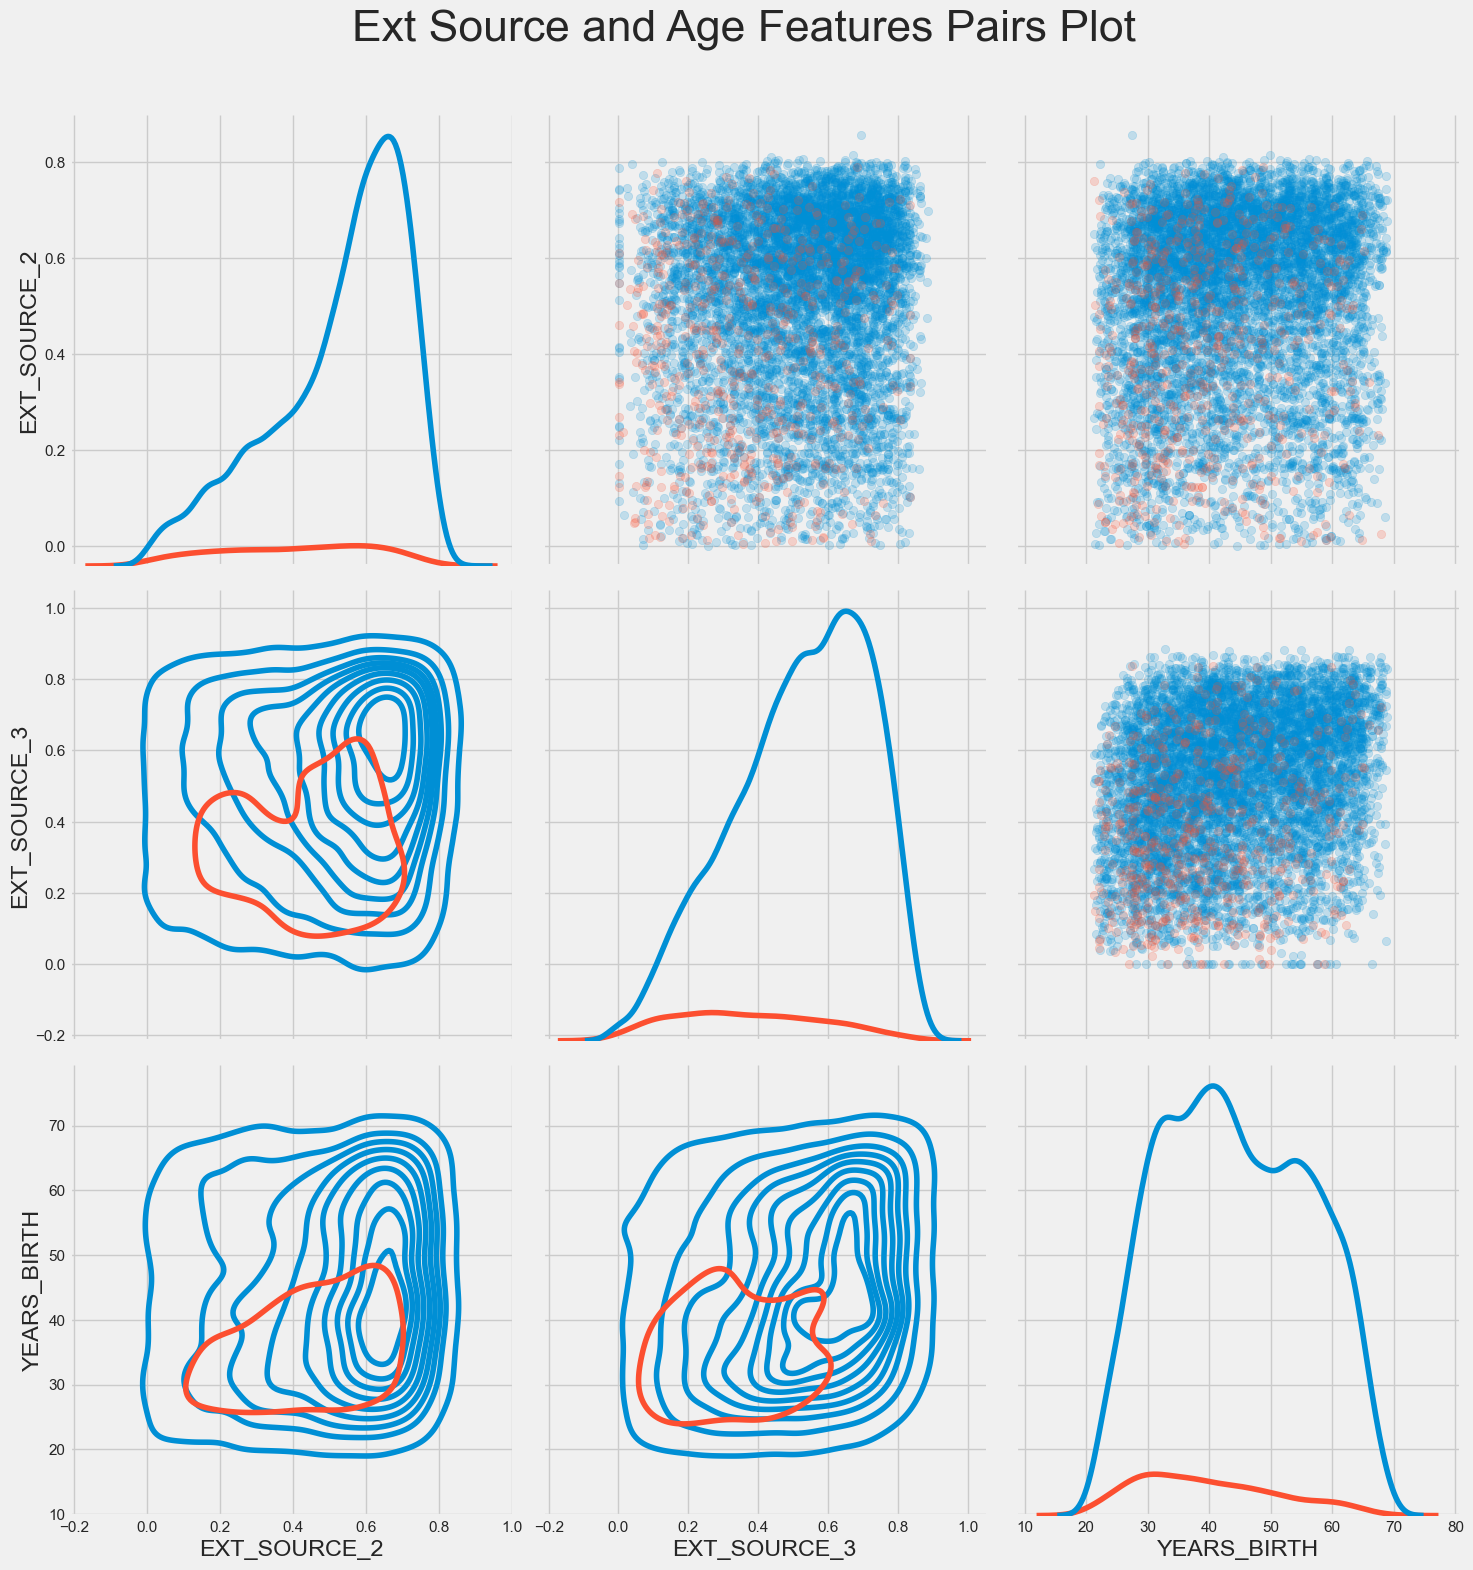

In [86]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:10000, :]

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False, height=5, aspect=1, 
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

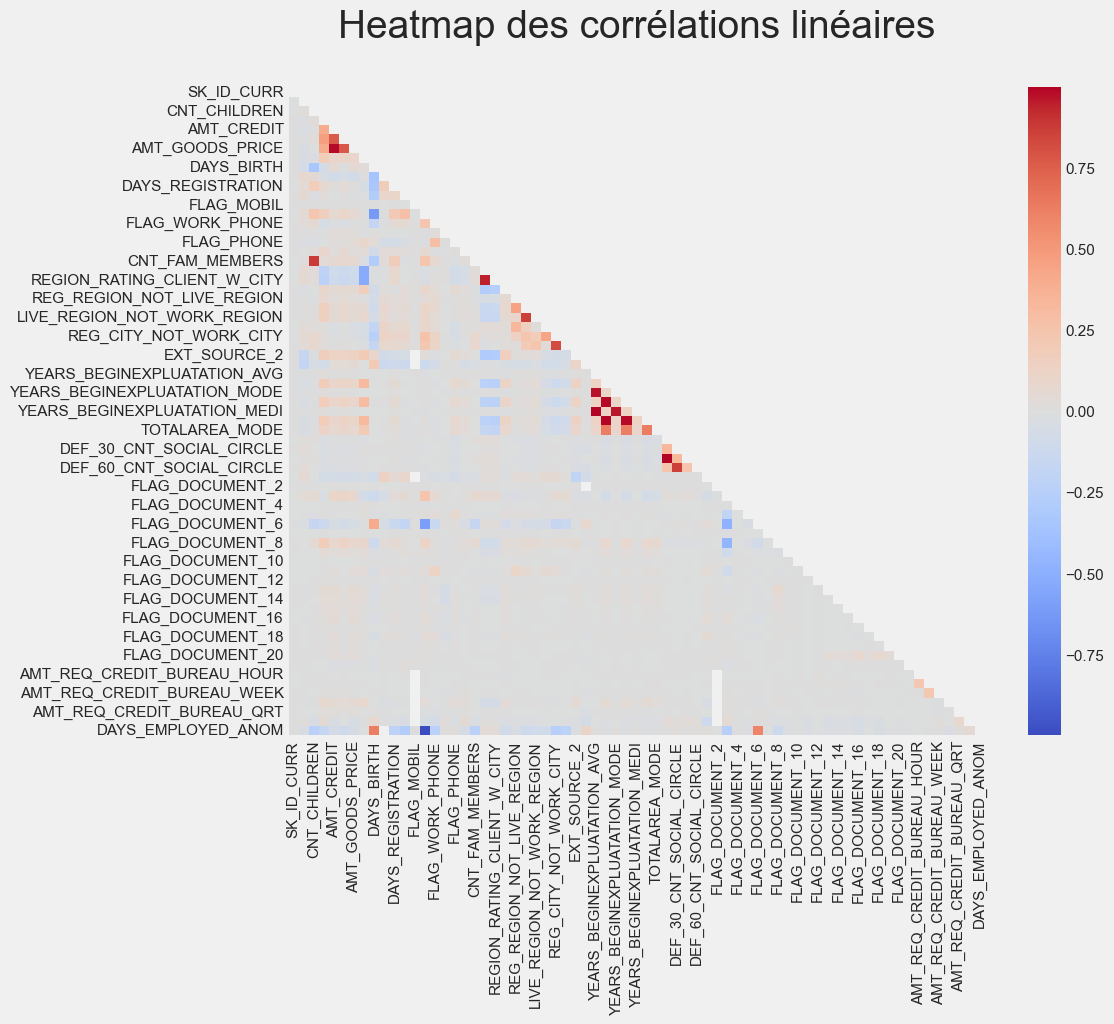

In [87]:
corr = df_train2.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr, annot=False, fmt=".2f", annot_kws={'size':6}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", 
          fontsize=28)
plt.show()

# Feature engineering

## Aligning Data

In [73]:
print(df_train2.shape)
print(application_test.shape)

(305900, 82)
(48744, 121)


In [74]:
## Aligning Training and Testing Data¶
train_labels = df_train2['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_train2,df_test = df_train2.align(application_test, join = 'inner', axis = 1)

# Add the target back in
df_train2['TARGET'] = train_labels

print('Training Features shape: ',df_train2.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (305900, 81)
Testing Features shape:  (48744, 80)


In [75]:
df_train2.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
      

## Expertise métier

CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income <br>
ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income <br>
CREDIT_TERM: payment rate <br>
DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age <br>

In [76]:
 def new_features_domain(df) : 

    df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

    return df

In [77]:
df_train3 = new_features_domain(df_train2)

In [78]:
df_train3.shape

(305900, 85)

In [94]:
def visu(df): 
    #visualization
    plt.figure(figsize = (12, 20))
    # iterate through the new features
    for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

        # create a new subplot for each source
        plt.subplot(4, 1, i + 1)
        # plot repaid loans
        sns.kdeplot(df.loc[df['TARGET'] == 0, feature], color="green", label = 'target == 0')
        # plot loans that were not repaid
        sns.kdeplot(df.loc[df['TARGET'] == 1, feature], color="red", label = 'target == 1')

        # Label the plots
        plt.title('Distribution of %s by Target Value' % feature)
        plt.xlabel('%s' % feature); plt.ylabel('Density');

    plt.tight_layout(h_pad = 2.5)

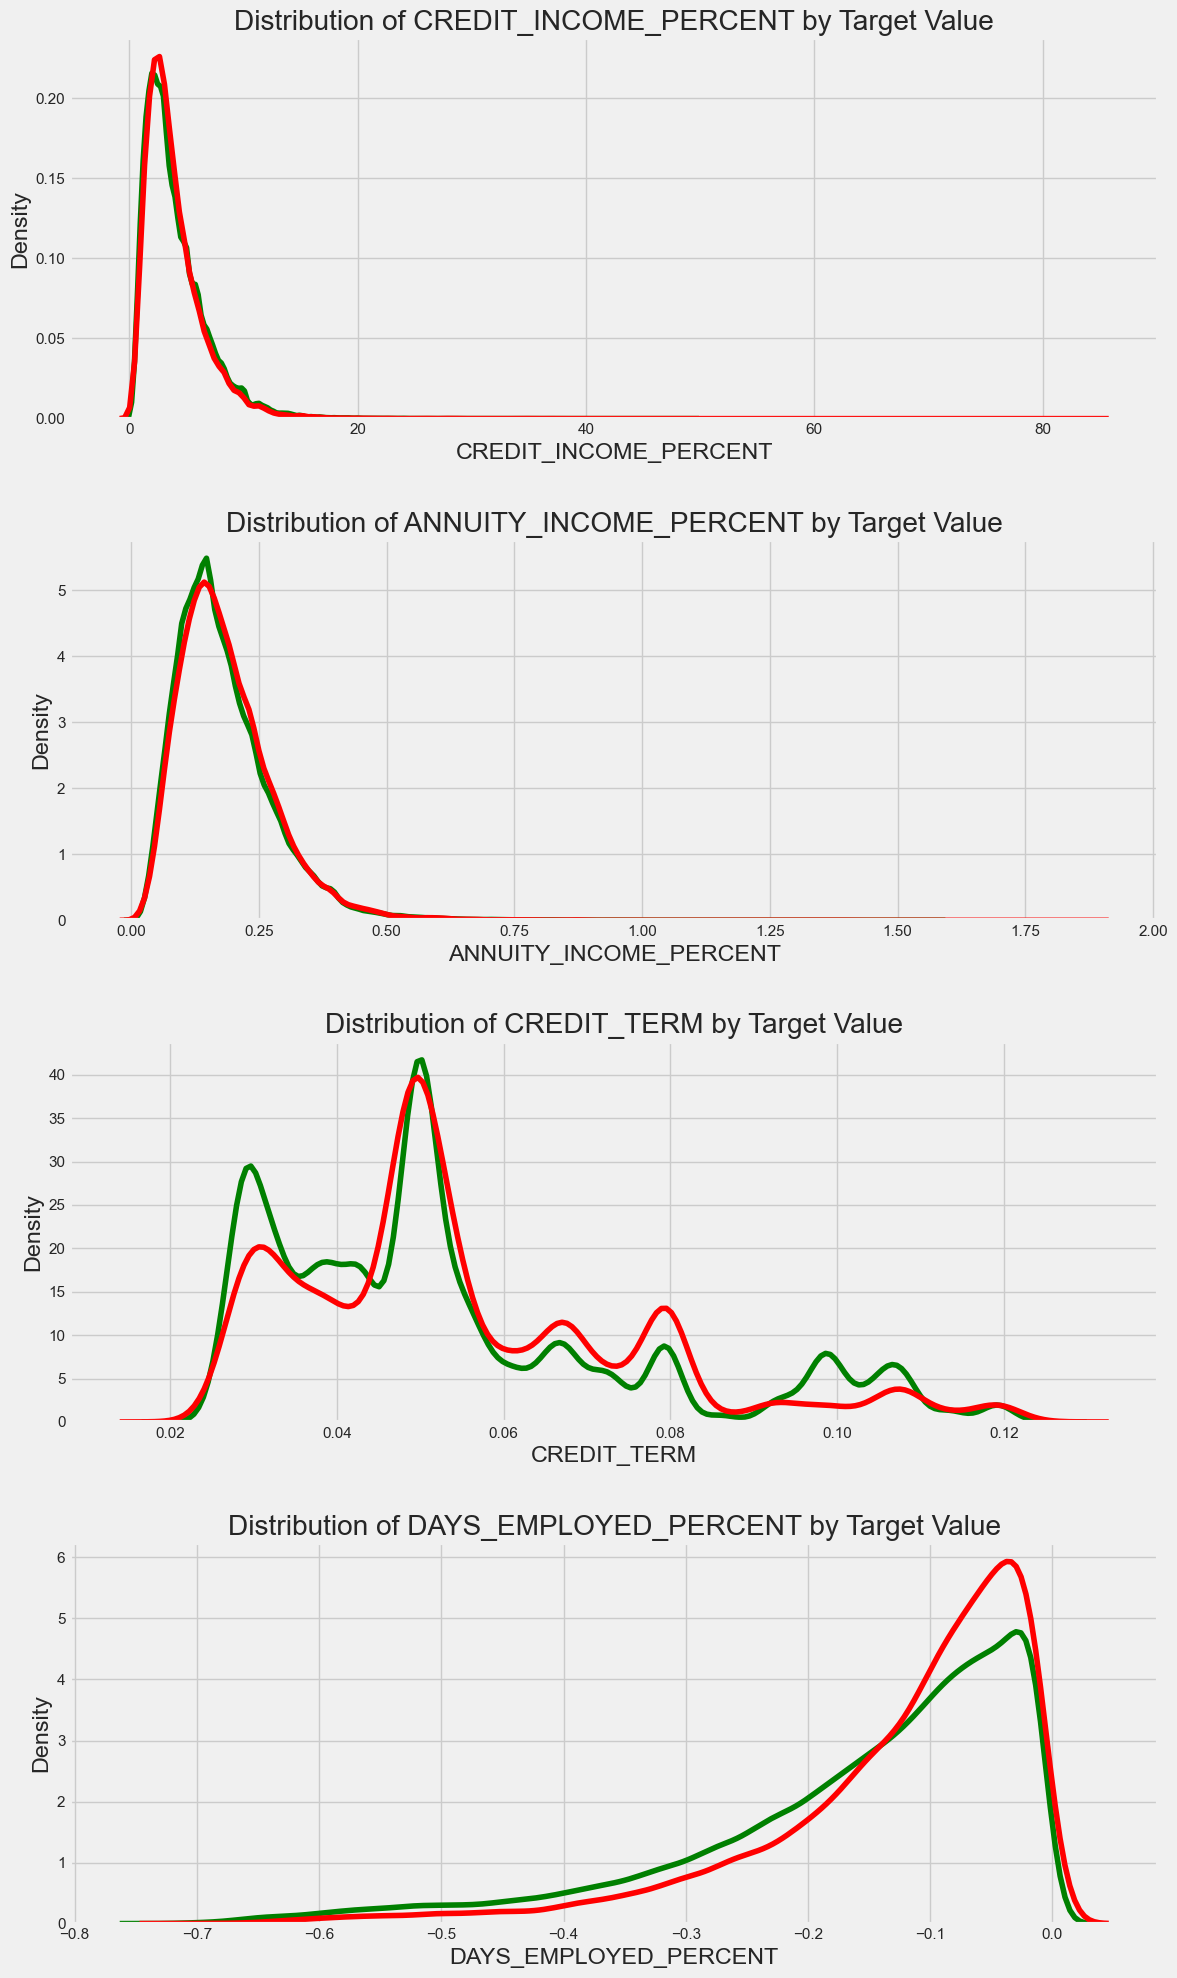

In [95]:
visu(df_train3)

In [81]:
df_test2 = new_features_domain(df_test)

In [82]:
df_test2.shape

(48744, 84)

## Feature transform

### Encoding categorical data

In [79]:
df_train3.select_dtypes('object').head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN


In [83]:
df_test2['CODE_GENDER'].unique()

array(['F', 'M'], dtype=object)

Object-type attribute that has value that can be ranked is NAME_EDUCATION_TYPE. That attribute can be ranked and transformed like this:

Lower secondary = 0

Secondary / secondary special = 1

Incomplete higher = 2

Higher education = 3

Academic degree = 4

In [84]:
#Map the atribute into ordinal numbers from 0-4
scale_mapper = {'Lower secondary' : 0, 'Secondary / secondary special' : 1, 
'Incomplete higher' : 2, 'Higher education' : 3, 'Academic degree' : 4}

df_train3['NAME_EDUCATION_TYPE'] = df_train3['NAME_EDUCATION_TYPE'].replace(scale_mapper)

In [85]:
df_train3['NAME_EDUCATION_TYPE'].unique()

array([1, 3, 2, 0, 4])

In [86]:
df_test2['NAME_EDUCATION_TYPE'] = df_test2['NAME_EDUCATION_TYPE'].replace(scale_mapper)

In [87]:
print(df_test2.shape)
print(df_train3.shape)

(48744, 84)
(305900, 85)


In [88]:
ls_mod = list(df_train3.select_dtypes('object'))

In [89]:
print(ls_mod)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE']


### Label encoding and one hot encoding version

In [90]:
def feature_encoding(df) : 

    # Create a label encoder object
    le = LabelEncoder()
    le_count = 0

    # Iterate through the columns
    for col in df:
        if df[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col+ '_cat'] = le.transform(df[col])

                # Keep track of how many columns were label encoded
                le_count += 1
    print('%d columns were label encoded.' % le_count)
    return df

In [91]:
df_train_le = feature_encoding(df_train3)

4 columns were label encoded.


In [92]:
df_test_le = feature_encoding(df_test2)

4 columns were label encoded.


In [93]:
print(df_train_le.shape)
print(df_test_le.shape)

(305900, 89)
(48744, 88)


In [94]:
df_train_le.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,NAME_CONTRACT_TYPE_cat,CODE_GENDER_cat,FLAG_OWN_CAR_cat,FLAG_OWN_REALTY_cat
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,1,Single / not married,House / apartment,0.018801,9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1,2.007889,0.121978,0.060749,-0.067329,0,1,0,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,3,Married,House / apartment,0.003541,16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.790750,0.132217,0.027598,-0.070862,0,0,0,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,1,Single / not married,House / apartment,0.010032,19046,-225.0,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.000000,0.100000,0.050000,-0.011814,1,1,1,1
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,1,Civil marriage,House / apartment,0.008019,19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,2.316167,0.219900,0.094941,-0.159905,0,0,0,1
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,1,Single / not married,House / apartment,0.028663,19932,-3038.0,-4311.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.222222,0.179963,0.042623,-0.152418,0,1,0,1


In [95]:
df_train_le.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [96]:
df_train_le.shape

(305900, 89)

In [97]:
# one-hot encoding of categorical variables

def onehotencode_feat(df, min_frequency=.03):
    
    #create a one hot encoder object

    oh= OneHotEncoder(sparse_output=False, dtype='int64', min_frequency=min_frequency).set_output(transform="pandas")
    
    cols = []
    for col in df.select_dtypes('object').columns:
        if df[col].nunique() > 2:
            cols.append(col)
                
                
    one_hot_encoded=oh.fit_transform(df[cols])

    print('Training ohe Features : ',one_hot_encoded.columns)
    df_ohe = pd.concat([df, one_hot_encoded],axis=1)
    return df_ohe

In [98]:
df_train_ohe = onehotencode_feat(df_train_le)

Training ohe Features :  Index(['NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Spouse, partner',
       'NAME_TYPE_SUITE_Unaccompanied', 'NAME_TYPE_SUITE_infrequent_sklearn',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Working',
       'NAME_INCOME_TYPE_infrequent_sklearn',
       'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
       'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_FAMILY_STATUS_infrequent_sklearn',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_With parents',
       'NAME_HOUSING_TYPE_infrequent_sklearn', 'OCCUPATION_TYPE_Accountants',
       'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Drivers',
       'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_Laborers',
       'OCCUPATION_TYPE_Managers', 'OCCUPATI

In [99]:
df_train_ohe.shape

(305900, 132)

In [100]:
df_train_ohe.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [101]:
df_test_ohe = onehotencode_feat(df_test_le)

Training ohe Features :  Index(['NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Unaccompanied',
       'NAME_TYPE_SUITE_infrequent_sklearn',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Working',
       'NAME_INCOME_TYPE_infrequent_sklearn',
       'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
       'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_With parents',
       'NAME_HOUSING_TYPE_infrequent_sklearn', 'OCCUPATION_TYPE_Accountants',
       'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Drivers',
       'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_Laborers',
       'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Sales staff',
       'OCCUPATION_TYPE_nan', 'OCCUPATION_TYPE_infrequent_skl

In [102]:
df_test_ohe.shape

(48744, 129)

In [103]:
def compare_df(df1,df2): 
    # Récupération des noms de colonnes
    columns_df1 = set(df1.columns)
    columns_df2 = set(df2.columns)

    # Comparaison des colonnes
    if columns_df1 == columns_df2:
        print("Les DataFrames ont les mêmes colonnes.")
    else:
        columns_only_in_df1 = columns_df1 - columns_df2
        columns_only_in_df2 = columns_df2 - columns_df1
        print("Colonnes uniquement dans df1 :", columns_only_in_df1)
        print("Colonnes uniquement dans df2 :", columns_only_in_df2)

In [104]:
compare_df(df_train_ohe, df_test_ohe)

Colonnes uniquement dans df1 : {'TARGET', 'NAME_FAMILY_STATUS_infrequent_sklearn', 'NAME_TYPE_SUITE_Spouse, partner'}
Colonnes uniquement dans df2 : set()


In [116]:
df_train_ohe2 = df_train_ohe.drop(columns = ['NAME_TYPE_SUITE_Spouse, partner', 'NAME_FAMILY_STATUS_infrequent_sklearn'])

In [106]:
df_train_ohe2.to_csv('data_P7_clean.csv', index=False)

### Full label encoding version

In [122]:
def lbl_features_encoding(df): 
    lbl = LabelEncoder()

    for col in df:
        if df[col].dtype == 'object':
            df[col + '_cat'] = lbl.fit_transform(df[col])

df_train2.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

In [123]:
df_train2.shape

(305900, 89)

In [124]:
df_train2.filter(regex='cat',axis=1).head()

,NAME_CONTRACT_TYPE_cat,CODE_GENDER_cat,FLAG_OWN_CAR_cat,FLAG_OWN_REALTY_cat
0,0,1,0,1
1,0,0,0,0
2,1,1,1,1
3,0,0,0,1
4,0,1,0,1


Processing missing values
The dataset still includes some missing values The following is the methods to replace them:

quantitative variable replaced with the variable median
categorical variables replaced with the variable frequency
binary depending on case: 0 or add 3 option

# Feature engineering of other data

Functions from the kaggle : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script?utm_medium=email&utm_content=nov-18-has-completed-mentoring-session-student&bsft_clkid=c383d801-b816-4d91-bed2-bce1da1df289&bsft_uid=54d38473-b877-4917-828f-57101c869f00&bsft_mid=8b2cf8bc-ff00-49bd-ba21-f71f9e476cd2&bsft_eid=7244055d-47f0-a6f2-c394-7a20ebb3a726&bsft_txnid=71f40185-343e-4c6f-9a7d-c87d70160352&bsft_mime_type=html&bsft_ek=2023-06-09T08%3A34%3A41Z&bsft_aaid=a265d396-7432-4eb2-9c9a-ba5eea75629e&bsft_tv=13

In [107]:
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [108]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [120]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = df_train_ohe2
    return df

In [126]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = bureau_df
    bb = bureau_balance
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


In [127]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = previous_application
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [111]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = POS_CASH_balance
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [135]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = installments_payments_df
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [136]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = credit_card_balance_df
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [139]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    # Save the DataFrame in a CSV file
    df.to_csv(submission_file_name, index=False)

In [140]:
if __name__ == "__main__":
    submission_file_name = "df_train_full.csv"
    with timer("Full model run"):
        main()

Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 22s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 22s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 10s
Installments payments df shape: (339587, 26)
Process installments payments - done in 36s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 16s
Full model run - done in 277s
